# SAGAN with out Spectal Norm and TTUB

Below implementation uses SAGAN without Spectral Norm and TTUB. This uses wasserstein loss as a loss function and skips using spectral norm for Generator.

In [1]:
pip install numpy torch torchvision pillow tqdm tensorboard pytorch_image_generation_metrics

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def load_data(im_size, batch_size, workers, dataset, data_path):
    transform = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if dataset == 'cifar10':
        dataset = datasets.CIFAR10(data_path, train=True, transform=transform, download=True)
    else:
        assert False, f"Unknwn dataset: {dataset}"
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True,
                            pin_memory=True)
    return dataloader

In [3]:
from tqdm import trange
def generate_imgs(net_G, device, z_dim=128, size=5000, batch_size=128):
    net_G.eval()
    imgs = []
    with torch.no_grad():
        for start in trange(0, size, batch_size,
                            desc='Evaluating', ncols=0, leave=False):
            end = min(start + batch_size, size)
            z = torch.randn(end - start, z_dim).to(device)
            imgs.append(net_G(z).cpu())
    net_G.train()
    imgs = torch.cat(imgs, dim=0)
    imgs = (imgs + 1) / 2
    return imgs

In [4]:
import torch
import numpy as np
import torch.nn as nn


class Self_Attn(nn.Module):
    ''' Self attention Layer '''
    def __init__(self, in_channels, activation):
        super(Self_Attn, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
            inputs:
                x: input feature maps (B x C x W x H)
            returns:
                out: self attention value + input feature
                attention: B x N x N (N is width * height)
        '''
        B, C, W, H = x.size()
        proj_query = self.query_conv(x).view(B, -1, W * H).permute(0, 2, 1) # B x N x C
        proj_key = self.key_conv(x).view(B, -1, W * H) # B X C x N
        energy = torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B x N x N
        proj_value = self.value_conv(x).view(B, -1, W * H) # B x C x N
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B x C x N
        out = out.view(B, C, W, H)
        out = self.gamma * out + x
        return out, attention


class Generator(nn.Module):
    ''' Generator '''
    def __init__(self, batch_size, im_size=64, z_dim=100, conv_dim=64, adv_loss='hinge'):
        super(Generator, self).__init__()
        self.im_size = im_size
        Normalization = SpectralNorm if adv_loss == 'hinge' else lambda x: x
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.im_size)) - 2
        mult = 2 ** repeat_num # 8
        layer1.append(Normalization(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult # 512
        layer2.append(Normalization(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2) # 256
        layer3.append(Normalization(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        if self.im_size == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(Normalization(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)

        curr_dim = int(curr_dim / 2) # 128
        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(128, 'relu')
        self.attn2 = Self_Attn(64, 'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.l1(z)
        out = self.l2(out)
        out = self.l3(out)
        out, p1 = self.attn1(out)
        if self.im_size == 64:
            out = self.l4(out)
            out, p2 = self.attn2(out)
        out = self.last(out)
        return out


class Discriminator(nn.Module):
    ''' Discriminator '''

    def __init__(self, batch_size=64, im_size=64, conv_dim=64, adv_loss='hinge'):
        super(Discriminator, self).__init__()
        self.im_size = im_size
        Normalization = SpectralNorm if adv_loss == 'hinge' else lambda x: x
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(Normalization(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))
        curr_dim = conv_dim

        layer2.append(Normalization(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(Normalization(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        if self.im_size == 64:
            layer4 = []
            layer4.append(Normalization(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim * 2

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out, p1 = self.attn1(out)
        if self.im_size == 64:
            out = self.l4(out)
            out, p2 = self.attn2(out)
        out = self.last(out)
        return out.squeeze()

In [5]:
import torch
import torch.nn as nn


class SAGAN_Trainer:

    def __init__(self, args):
        self.args = args
        self._build_model()

    def _build_model(self):
        self.G = Generator(self.args.batch_size, self.args.im_size, self.args.z_dim, self.args.g_conv_dim, self.args.adv_loss)
        self.D = Discriminator(self.args.batch_size, self.args.im_size, self.args.d_conv_dim, self.args.adv_loss)
        self.G.to(self.args.device)
        self.D.to(self.args.device)
        if self.args.parallel:
            self.G = nn.DataParallel(self.G)
            self.D = nn.DataParallel(self.D)
        _G_params = filter(lambda p: p.requires_grad, self.G.parameters())
        _D_params = filter(lambda p: p.requires_grad, self.D.parameters())
        self.g_optimizer = torch.optim.Adam(_G_params, self.args.g_lr, [self.args.beta1, self.args.beta2])
        self.d_optimizer = torch.optim.Adam(_D_params, self.args.d_lr, [self.args.beta1, self.args.beta2])
        self.c_loss = nn.CrossEntropyLoss()

    def train(self, real_images):
        ''' train discriminator '''
        d_out_real = self.D(real_images)
        ''' compute loss with real images '''
        if self.args.adv_loss == 'wgan-gp':
            d_loss_real = -1 * torch.mean(d_out_real)
        elif self.args.adv_loss == 'hinge':
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
        ''' apply Gumbel Softmax '''
        z = torch.randn(real_images.size(0), self.args.z_dim).to(self.args.device)
        fake_images = self.G(z)
        d_out_fake = self.D(fake_images)
        ''' compute loss with fake images '''
        if self.args.adv_loss == 'wgan-gp':
            d_loss_fake = d_out_fake.mean()
        elif self.args.adv_loss == 'hinge':
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
        ''' update discriminator '''
        d_loss = d_loss_real + d_loss_fake
        self.d_optimizer.zero_grad()
        d_loss.backward()
        self.d_optimizer.step()
        if self.args.adv_loss == 'wgan-gp':
            ''' compute gradient penalty '''
            alpha = torch.rand(real_images.size(0), 1, 1, 1).to(self.args.device)
            interpolated = alpha * real_images.data + (1 - alpha) * fake_images.data
            interpolated.requires_grad_(True)
            d_out_itp = self.D(interpolated)
            grad = torch.autograd.grad(outputs=d_out_itp,
                                       inputs=interpolated,
                                       grad_outputs=torch.ones(d_out_itp.size()).to(self.args.device),
                                       retain_graph=True,
                                       create_graph=True,
                                       only_inputs=True)[0]
            grad_norm = grad.view(grad.size(0), -1).norm(dim=1)
            d_loss_gp = torch.mean((grad_norm - 1) ** 2)
            ''' optimize gradient penalty '''
            d_loss = self.args.lambda_gp * d_loss_gp
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()
        ''' train generator '''
        z = torch.randn(real_images.size(0), self.args.z_dim).to(self.args.device)
        fake_images = self.G(z)
        g_out_fake = self.D(fake_images)
        ''' compute loss with fake images '''
        g_loss_fake = -1 * g_out_fake.mean()
        self.g_optimizer.zero_grad()
        g_loss_fake.backward()
        self.g_optimizer.step()
        return d_loss_real.item(), d_loss_fake.item(), g_loss_fake.item()

In [9]:
import torch
from torch import nn
from torchvision.models.inception import inception_v3


class Scorer:

    def __init__(self, device, resize=True):
        self.resize = resize
        self.inception_model = inception_v3(pretrained=True, transform_input=False)
        self.inception_model.to(device)
        self.inception_model.eval()
        if self.resize:
            self.upsample = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True)
        self.softmax = nn.Softmax(dim=-1)

    @torch.no_grad()
    def get_preds(self, samples):
        mean = samples.new_tensor((0.485, 0.456, 0.406)).view(1, -1, 1, 1)
        std = samples.new_tensor((0.229, 0.224, 0.225)).view(1, -1, 1, 1)
        samples = (samples - mean) / std
        samples = self.upsample(samples) if self.resize else samples
        return self.softmax(self.inception_model(samples)).detach()

    @torch.no_grad()
    def compute_score(self, preds, splits=10):
        scores = list()
        total_num = preds.size(0)
        for k in range(splits):
            part = preds[k * (total_num//splits): (k+1) * (total_num//splits), :]
            kl = part * (part.log() - part.mean(dim=0, keepdim=True).log())
            scores.append(kl.sum(dim=1).mean().exp())
        scores = torch.stack(scores, dim=0)
        inception_score = torch.mean(scores).item()
        std = torch.std(scores).item()
        return inception_score, std

In [8]:
import torch
import torch.nn as nn


class SpectralNorm(nn.Module):

    def __init__(self, module, name='weight'):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        if not hasattr(self.module, self.name + '_bar'):
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + '_u')
        v = getattr(self.module, self.name + '_v')
        w = getattr(self.module, self.name + '_bar')
        height = w.size(0)
        with torch.no_grad():
            v = self._l2normalize(w.view(height, -1).transpose(0, 1).mv(u))
            u = self._l2normalize(w.view(height, -1).mv(v))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _make_params(self):
        w = getattr(self.module, self.name)
        height = w.size(0)
        width = w.view(height, -1).size(1)
        u = nn.Parameter(self._l2normalize(w.new_empty(height).normal_(0, 1)), requires_grad=False)
        v = nn.Parameter(self._l2normalize(w.new_empty(width).normal_(0, 1)), requires_grad=False)
        w_bar = nn.Parameter(w.data)
        del self.module._parameters[self.name]
        self.module.register_parameter(self.name + '_u', u)
        self.module.register_parameter(self.name + '_v', v)
        self.module.register_parameter(self.name + '_bar', w_bar)

    def forward(self, *args, **kwargs):
        self._update_u_v()
        return self.module.forward(*args, **kwargs)

    @staticmethod
    def _l2normalize(v, eps=1e-12):
        return v / (v.norm() + eps)

In [13]:
import os
import time
import torch
import random
from tqdm import tqdm
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from pytorch_image_generation_metrics import get_inception_score_and_fid

class Instructor:

    def __init__(self, dataset='cifar10', data_dir='data', sample_dir='sample', save_dir='saves', num_workers=16,
                 im_size=32, z_dim=128, g_conv_dim=64, d_conv_dim=64, total_step=200000, batch_size=64, g_lr=0.0004,
                 d_lr=0.0004, beta1=0.0, beta2=0.9, lambda_gp=10, adv_loss='wgan-gp', device=None, parallel=False,
                 log_step=20, sample_step=200, eval_step=500, model_save_step=10, sample_num=100, timestamp=None, num_images = 50000):

        # Assign all argument values to class variables
        self.dataset = dataset
        self.data_dir = data_dir
        self.sample_dir = sample_dir
        self.save_dir = save_dir
        self.num_workers = num_workers
        self.im_size = im_size
        self.z_dim = z_dim
        self.g_conv_dim = g_conv_dim
        self.d_conv_dim = d_conv_dim
        self.total_step = total_step
        self.batch_size = batch_size
        # ttuf
        self.g_lr = g_lr
        self.d_lr = d_lr


        self.beta1 = beta1
        self.beta2 = beta2
        self.lambda_gp = lambda_gp
        self.adv_loss = adv_loss
        self.device = torch.device(device if device else 'cuda' if torch.cuda.is_available() else 'cpu')
        self.parallel = parallel
        self.log_step = log_step
        self.sample_step = sample_step
        self.eval_step = eval_step
        self.model_save_step = model_save_step
        self.sample_num = sample_num
        self.timestamp = timestamp if timestamp else str(int(time.time())) + format(random.randint(0, 999), '03')
        self.num_images = num_images
        self.fid_cache = './stats/cifar10.train.npz'  # FID cache
        self.fid_scores = []
        self.inception_scores = []
        # Create directories
        # Ensure directories exist
        for dir_name in [self.data_dir, self.sample_dir, self.save_dir]:
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
        os.mkdir(os.path.join(self.sample_dir, self.timestamp))
        os.mkdir(os.path.join(self.save_dir, self.timestamp))

        # Set environment settings
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        torch.backends.cudnn.benchmark = True

        self._print_args()

    def _print_args(self):
        print('TRAINING ARGUMENTS:')
        for key, value in vars(self).items():
            print(f">>> {key}: {value}")
    def get_FID(self):
      return self.fid_scores;
    def get_IS(self):
      return self.inception_scores;

    def train_sagan(self):
        print('=> creating model...')
        trainer = SAGAN_Trainer(self)
        writer = SummaryWriter()
        print('=> creating scorer...')
        scorer = Scorer(device=self.device, resize=True)
        print('=> loading data...')
        dataloader = load_data(im_size=self.im_size,
                               batch_size=self.batch_size,
                               workers=self.num_workers,
                               dataset=self.dataset,
                               data_path=os.path.join(self.data_dir, self.dataset))
        data_iter = iter(dataloader)
        model_save_step = int(self.model_save_step * len(dataloader))
        fixed_z = torch.randn(self.batch_size, self.z_dim).to(self.device)
        real_images, _ = next(data_iter)
        real_images = (real_images * 0.5 + 0.5).clamp(0, 1)
        writer.add_images('real', real_images, 0)
        save_image(real_images, os.path.join(self.sample_dir, self.timestamp, 'real.png'))
        all_preds = list()
        for inputs, _ in tqdm(dataloader):
            inputs = inputs.to(self.device) * 0.5 + 0.5
            all_preds.append(scorer.get_preds(inputs))
        score, _ = scorer.compute_score(torch.cat(all_preds, dim=0), splits=10)
        print(f"real inception score: {score:.4f}")
        best_score = 0

        for step in range(self.total_step):
            ''' train sagan model '''
            trainer.D.train()
            trainer.G.train()
            try:
                real_images, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(dataloader)
                real_images, _ = next(data_iter)
            real_images = real_images.to(self.device)
            d_loss_real, d_loss_fake, g_loss_fake = trainer.train(real_images)
            ''' print info '''
            if (step + 1) % self.log_step == 0:
                print(f"step: {step + 1}/{self.total_step}, g_loss_fake: {g_loss_fake:.4f}")
                writer.add_scalar('Loss/D_real', d_loss_real, step + 1)
                writer.add_scalar('Loss/D_fake', d_loss_fake, step + 1)
                writer.add_scalar('Loss/G_fake', g_loss_fake, step + 1)
                writer.add_scalar('Score/G_attn1', trainer.G.attn1.gamma.mean().item(), step + 1)
                writer.add_scalar('Score/D_attn1', trainer.D.attn1.gamma.mean().item(), step + 1)
            ''' compute inception score '''
            if (step + 1) % self.eval_step == 0:
                trainer.G.eval()
                all_preds = list()
                for _ in tqdm(range(self.sample_num)):
                    z = torch.randn(self.batch_size, self.z_dim).to(self.device)
                    inputs = trainer.G(z) * 0.5 + 0.5
                    all_preds.append(scorer.get_preds(inputs))
                score, _ = scorer.compute_score(torch.cat(all_preds, dim=0), splits=10)
                best_score = max(score, best_score)
                print(f"fake inception score: {score:.4f}")
                writer.add_scalar('Score/IS_fake', score, step + 1)
                imgs = generate_imgs(
                        trainer.G, self.device, self.z_dim,
                        self.num_images, self.batch_size)


                IS, FID = get_inception_score_and_fid(
                        imgs, self.fid_cache, verbose=True)
                self.fid_scores.append([step, FID])
                self.inception_scores.append([step, IS[0]])
                print(
                        "%s/%s Inception Score: %.3f(%.5f), "
                        "FID: %6.3f" % (
                            step, self.total_step, IS[0], IS[1], FID))
                writer.add_scalar('Inception_Score', IS[0], step)
                writer.add_scalar('Inception_Score_std', IS[1], step)
                writer.add_scalar('FID', FID, step)
            ''' sample image '''
            if (step + 1) % self.sample_step == 0:
                trainer.G.eval()
                fake_images = trainer.G(fixed_z)
                fake_images = (fake_images * 0.5 + 0.5).clamp(0, 1)
                writer.add_images('fake', fake_images, step + 1)
                save_image(fake_images, os.path.join(self.sample_dir, self.timestamp, f"fake_{step + 1}.png"))
            ''' save model '''
            if (step + 1) % model_save_step == 0:
                torch.save(trainer.G.state_dict(), os.path.join(self.save_dir, self.timestamp, f"{step + 1}_G.pt"))
                torch.save(trainer.D.state_dict(), os.path.join(self.save_dir, self.timestamp, f"{step + 1}_D.pt"))
        writer.close()
        print(f"best inception score: {best_score:.4f}")





In [14]:
ins = Instructor()
ins.train_sagan()
ins

TRAINING ARGUMENTS:
>>> dataset: cifar10
>>> data_dir: data
>>> sample_dir: sample
>>> save_dir: saves
>>> num_workers: 16
>>> im_size: 32
>>> z_dim: 128
>>> g_conv_dim: 64
>>> d_conv_dim: 64
>>> total_step: 200000
>>> batch_size: 64
>>> g_lr: 0.0004
>>> d_lr: 0.0004
>>> beta1: 0.0
>>> beta2: 0.9
>>> lambda_gp: 10
>>> adv_loss: wgan-gp
>>> device: cuda
>>> parallel: False
>>> log_step: 20
>>> sample_step: 200
>>> eval_step: 500
>>> model_save_step: 10
>>> sample_num: 100
>>> timestamp: 1726322856811
>>> num_images: 50000
>>> fid_cache: ./stats/cifar10.train.npz
>>> fid_scores: []
>>> inception_scores: []
=> creating model...
=> creating scorer...
=> loading data...
Files already downloaded and verified


100%|██████████| 781/781 [00:23<00:00, 33.33it/s]


real inception score: 10.2081
step: 20/200000, g_loss_fake: 19.2062
step: 40/200000, g_loss_fake: 0.7893
step: 60/200000, g_loss_fake: 10.7399
step: 80/200000, g_loss_fake: 12.2541
step: 100/200000, g_loss_fake: 5.1663
step: 120/200000, g_loss_fake: 9.8576
step: 140/200000, g_loss_fake: 8.1383
step: 160/200000, g_loss_fake: 7.5986
step: 180/200000, g_loss_fake: 9.3349
step: 200/200000, g_loss_fake: 7.8308
step: 220/200000, g_loss_fake: 7.0486
step: 240/200000, g_loss_fake: 8.7544
step: 260/200000, g_loss_fake: 8.4878
step: 280/200000, g_loss_fake: 6.3679
step: 300/200000, g_loss_fake: 6.0184
step: 320/200000, g_loss_fake: 3.3611
step: 340/200000, g_loss_fake: 8.9399
step: 360/200000, g_loss_fake: 7.2168
step: 380/200000, g_loss_fake: 6.3872
step: 400/200000, g_loss_fake: 6.4923
step: 420/200000, g_loss_fake: 7.0699
step: 440/200000, g_loss_fake: 7.6914
step: 460/200000, g_loss_fake: 7.3622
step: 480/200000, g_loss_fake: 6.2596
step: 500/200000, g_loss_fake: 4.1760


100%|██████████| 100/100 [00:02<00:00, 33.33it/s]


fake inception score: 2.0686


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

499/200000 Inception Score: 2.345(0.02228), FID: 202.699
step: 520/200000, g_loss_fake: 5.9387
step: 540/200000, g_loss_fake: 7.2549
step: 560/200000, g_loss_fake: 4.8406
step: 580/200000, g_loss_fake: 7.5246
step: 600/200000, g_loss_fake: 4.4532
step: 620/200000, g_loss_fake: 5.2095
step: 640/200000, g_loss_fake: 3.2287
step: 660/200000, g_loss_fake: 6.1949
step: 680/200000, g_loss_fake: 4.3710
step: 700/200000, g_loss_fake: 6.1645
step: 720/200000, g_loss_fake: 4.4387
step: 740/200000, g_loss_fake: 4.7562
step: 760/200000, g_loss_fake: 3.0414
step: 780/200000, g_loss_fake: 2.9995
step: 800/200000, g_loss_fake: 3.0097
step: 820/200000, g_loss_fake: 4.3296
step: 840/200000, g_loss_fake: 2.6070
step: 860/200000, g_loss_fake: 3.7810
step: 880/200000, g_loss_fake: 2.7296
step: 900/200000, g_loss_fake: 1.9776
step: 920/200000, g_loss_fake: 3.7825
step: 940/200000, g_loss_fake: 5.0760
step: 960/200000, g_loss_fake: 1.8053
step: 980/200000, g_loss_fake: 3.4747
step: 1000/200000, g_loss_fake:

100%|██████████| 100/100 [00:02<00:00, 33.49it/s]


fake inception score: 2.3242


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

999/200000 Inception Score: 2.366(0.03163), FID: 176.776
step: 1020/200000, g_loss_fake: 3.6667
step: 1040/200000, g_loss_fake: 2.8847
step: 1060/200000, g_loss_fake: 2.6880
step: 1080/200000, g_loss_fake: 2.6893
step: 1100/200000, g_loss_fake: 2.8914
step: 1120/200000, g_loss_fake: 0.6744
step: 1140/200000, g_loss_fake: 1.9179
step: 1160/200000, g_loss_fake: 2.5740
step: 1180/200000, g_loss_fake: 1.9810
step: 1200/200000, g_loss_fake: 1.4415
step: 1220/200000, g_loss_fake: 1.9616
step: 1240/200000, g_loss_fake: 2.2376
step: 1260/200000, g_loss_fake: 3.3644
step: 1280/200000, g_loss_fake: 3.6699
step: 1300/200000, g_loss_fake: 2.8753
step: 1320/200000, g_loss_fake: 2.6755
step: 1340/200000, g_loss_fake: 3.1037
step: 1360/200000, g_loss_fake: 1.6379
step: 1380/200000, g_loss_fake: 2.6917
step: 1400/200000, g_loss_fake: 1.1638
step: 1420/200000, g_loss_fake: 4.3692
step: 1440/200000, g_loss_fake: 1.3372
step: 1460/200000, g_loss_fake: 1.5749
step: 1480/200000, g_loss_fake: 1.0770
step: 1

100%|██████████| 100/100 [00:02<00:00, 33.60it/s]


fake inception score: 2.5880


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

1499/200000 Inception Score: 3.145(0.02951), FID: 148.374
step: 1520/200000, g_loss_fake: 1.7066
step: 1540/200000, g_loss_fake: 1.5468
step: 1560/200000, g_loss_fake: 1.0231
step: 1580/200000, g_loss_fake: 2.0317
step: 1600/200000, g_loss_fake: 1.5681
step: 1620/200000, g_loss_fake: 1.7050
step: 1640/200000, g_loss_fake: 1.1908
step: 1660/200000, g_loss_fake: 0.0551
step: 1680/200000, g_loss_fake: 2.5289
step: 1700/200000, g_loss_fake: 2.6423
step: 1720/200000, g_loss_fake: -0.0336
step: 1740/200000, g_loss_fake: 0.6913
step: 1760/200000, g_loss_fake: 0.4206
step: 1780/200000, g_loss_fake: 2.2852
step: 1800/200000, g_loss_fake: 2.3186
step: 1820/200000, g_loss_fake: 0.8205
step: 1840/200000, g_loss_fake: 1.5701
step: 1860/200000, g_loss_fake: 0.4332
step: 1880/200000, g_loss_fake: 0.7010
step: 1900/200000, g_loss_fake: 1.6038
step: 1920/200000, g_loss_fake: 2.4037
step: 1940/200000, g_loss_fake: 0.4184
step: 1960/200000, g_loss_fake: -0.6603
step: 1980/200000, g_loss_fake: 1.5016
step

100%|██████████| 100/100 [00:02<00:00, 33.61it/s]


fake inception score: 2.8683


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

1999/200000 Inception Score: 3.516(0.03031), FID: 129.723
step: 2020/200000, g_loss_fake: 2.0023
step: 2040/200000, g_loss_fake: 1.0784
step: 2060/200000, g_loss_fake: 1.7212
step: 2080/200000, g_loss_fake: -0.3805
step: 2100/200000, g_loss_fake: -0.0933
step: 2120/200000, g_loss_fake: 3.1925
step: 2140/200000, g_loss_fake: -1.0577
step: 2160/200000, g_loss_fake: 0.8029
step: 2180/200000, g_loss_fake: 0.5527
step: 2200/200000, g_loss_fake: 0.8104
step: 2220/200000, g_loss_fake: -0.3924
step: 2240/200000, g_loss_fake: -0.2600
step: 2260/200000, g_loss_fake: 0.8327
step: 2280/200000, g_loss_fake: 0.1549
step: 2300/200000, g_loss_fake: 0.2420
step: 2320/200000, g_loss_fake: -0.9422
step: 2340/200000, g_loss_fake: -1.8546
step: 2360/200000, g_loss_fake: 0.8540
step: 2380/200000, g_loss_fake: 0.2853
step: 2400/200000, g_loss_fake: -0.8275
step: 2420/200000, g_loss_fake: -0.5425
step: 2440/200000, g_loss_fake: 1.3360
step: 2460/200000, g_loss_fake: 2.0961
step: 2480/200000, g_loss_fake: 0.12

100%|██████████| 100/100 [00:03<00:00, 33.13it/s]


fake inception score: 3.0471


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

2499/200000 Inception Score: 3.933(0.04610), FID: 112.227
step: 2520/200000, g_loss_fake: 0.4886
step: 2540/200000, g_loss_fake: -0.1565
step: 2560/200000, g_loss_fake: 0.9227
step: 2580/200000, g_loss_fake: 0.0530
step: 2600/200000, g_loss_fake: -2.0310
step: 2620/200000, g_loss_fake: 0.2918
step: 2640/200000, g_loss_fake: 0.3350
step: 2660/200000, g_loss_fake: 1.2401
step: 2680/200000, g_loss_fake: 0.5061
step: 2700/200000, g_loss_fake: -1.0836
step: 2720/200000, g_loss_fake: 1.5734
step: 2740/200000, g_loss_fake: 0.1099
step: 2760/200000, g_loss_fake: 1.1402
step: 2780/200000, g_loss_fake: 0.4181
step: 2800/200000, g_loss_fake: -2.2499
step: 2820/200000, g_loss_fake: -0.8755
step: 2840/200000, g_loss_fake: 1.8794
step: 2860/200000, g_loss_fake: -1.9031
step: 2880/200000, g_loss_fake: 0.5910
step: 2900/200000, g_loss_fake: 0.4692
step: 2920/200000, g_loss_fake: -0.2730
step: 2940/200000, g_loss_fake: -1.4026
step: 2960/200000, g_loss_fake: 0.3605
step: 2980/200000, g_loss_fake: -0.42

100%|██████████| 100/100 [00:03<00:00, 33.23it/s]


fake inception score: 3.3401


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

2999/200000 Inception Score: 4.133(0.04696), FID: 107.753
step: 3020/200000, g_loss_fake: 0.1259
step: 3040/200000, g_loss_fake: 2.1075
step: 3060/200000, g_loss_fake: -0.2122
step: 3080/200000, g_loss_fake: 1.6765
step: 3100/200000, g_loss_fake: 0.1901
step: 3120/200000, g_loss_fake: 1.0892
step: 3140/200000, g_loss_fake: 1.2167
step: 3160/200000, g_loss_fake: -0.6453
step: 3180/200000, g_loss_fake: -1.1257
step: 3200/200000, g_loss_fake: 0.9219
step: 3220/200000, g_loss_fake: 1.3295
step: 3240/200000, g_loss_fake: 1.9028
step: 3260/200000, g_loss_fake: 0.3655
step: 3280/200000, g_loss_fake: 1.7237
step: 3300/200000, g_loss_fake: -0.7062
step: 3320/200000, g_loss_fake: -0.6141
step: 3340/200000, g_loss_fake: -0.1921
step: 3360/200000, g_loss_fake: -1.3176
step: 3380/200000, g_loss_fake: -0.5959
step: 3400/200000, g_loss_fake: 2.0427
step: 3420/200000, g_loss_fake: 0.2976
step: 3440/200000, g_loss_fake: 2.3082
step: 3460/200000, g_loss_fake: 0.8450
step: 3480/200000, g_loss_fake: -0.14

100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


fake inception score: 3.5284


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

3499/200000 Inception Score: 4.362(0.03590), FID: 92.158
step: 3520/200000, g_loss_fake: 1.2821
step: 3540/200000, g_loss_fake: 0.4212
step: 3560/200000, g_loss_fake: -0.6800
step: 3580/200000, g_loss_fake: 1.0903
step: 3600/200000, g_loss_fake: -0.1911
step: 3620/200000, g_loss_fake: -0.8459
step: 3640/200000, g_loss_fake: -0.5250
step: 3660/200000, g_loss_fake: -0.8937
step: 3680/200000, g_loss_fake: -1.8104
step: 3700/200000, g_loss_fake: 1.1029
step: 3720/200000, g_loss_fake: 0.6246
step: 3740/200000, g_loss_fake: 0.3095
step: 3760/200000, g_loss_fake: 1.2580
step: 3780/200000, g_loss_fake: -1.7285
step: 3800/200000, g_loss_fake: 0.1386
step: 3820/200000, g_loss_fake: -0.8494
step: 3840/200000, g_loss_fake: -0.8262
step: 3860/200000, g_loss_fake: 0.1547
step: 3880/200000, g_loss_fake: -0.6296
step: 3900/200000, g_loss_fake: 0.8638
step: 3920/200000, g_loss_fake: -0.2738
step: 3940/200000, g_loss_fake: -0.1387
step: 3960/200000, g_loss_fake: -0.1063
step: 3980/200000, g_loss_fake: 0

100%|██████████| 100/100 [00:02<00:00, 33.61it/s]


fake inception score: 3.4532


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

3999/200000 Inception Score: 4.513(0.05392), FID: 83.046
step: 4020/200000, g_loss_fake: 0.7373
step: 4040/200000, g_loss_fake: -0.8121
step: 4060/200000, g_loss_fake: -0.5777
step: 4080/200000, g_loss_fake: 0.1511
step: 4100/200000, g_loss_fake: -0.2632
step: 4120/200000, g_loss_fake: 0.5105
step: 4140/200000, g_loss_fake: 0.3693
step: 4160/200000, g_loss_fake: -1.4753
step: 4180/200000, g_loss_fake: 0.5108
step: 4200/200000, g_loss_fake: 1.4990
step: 4220/200000, g_loss_fake: 1.6726
step: 4240/200000, g_loss_fake: -0.4340
step: 4260/200000, g_loss_fake: -0.7768
step: 4280/200000, g_loss_fake: -0.1529
step: 4300/200000, g_loss_fake: 0.8448
step: 4320/200000, g_loss_fake: -0.8961
step: 4340/200000, g_loss_fake: -0.0073
step: 4360/200000, g_loss_fake: -1.1368
step: 4380/200000, g_loss_fake: 0.1419
step: 4400/200000, g_loss_fake: 2.5990
step: 4420/200000, g_loss_fake: -0.3248
step: 4440/200000, g_loss_fake: 1.1367
step: 4460/200000, g_loss_fake: 0.7484
step: 4480/200000, g_loss_fake: 1.0

100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


fake inception score: 3.7808


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

4499/200000 Inception Score: 4.746(0.05732), FID: 77.340
step: 4520/200000, g_loss_fake: 1.5104
step: 4540/200000, g_loss_fake: -1.0943
step: 4560/200000, g_loss_fake: 1.1226
step: 4580/200000, g_loss_fake: 1.2775
step: 4600/200000, g_loss_fake: 0.3494
step: 4620/200000, g_loss_fake: 0.1140
step: 4640/200000, g_loss_fake: -0.7688
step: 4660/200000, g_loss_fake: 1.3773
step: 4680/200000, g_loss_fake: -0.3367
step: 4700/200000, g_loss_fake: 2.4797
step: 4720/200000, g_loss_fake: -0.4782
step: 4740/200000, g_loss_fake: -0.3862
step: 4760/200000, g_loss_fake: -1.8086
step: 4780/200000, g_loss_fake: 0.0223
step: 4800/200000, g_loss_fake: 0.4227
step: 4820/200000, g_loss_fake: -0.9072
step: 4840/200000, g_loss_fake: 0.7417
step: 4860/200000, g_loss_fake: 0.5537
step: 4880/200000, g_loss_fake: 0.5579
step: 4900/200000, g_loss_fake: -0.4591
step: 4920/200000, g_loss_fake: 1.1559
step: 4940/200000, g_loss_fake: 1.0445
step: 4960/200000, g_loss_fake: 0.4769
step: 4980/200000, g_loss_fake: 0.4623

100%|██████████| 100/100 [00:02<00:00, 33.63it/s]


fake inception score: 3.7864


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

4999/200000 Inception Score: 5.090(0.04859), FID: 73.503
step: 5020/200000, g_loss_fake: 0.8367
step: 5040/200000, g_loss_fake: 0.8413
step: 5060/200000, g_loss_fake: -0.5115
step: 5080/200000, g_loss_fake: 0.2144
step: 5100/200000, g_loss_fake: -0.3466
step: 5120/200000, g_loss_fake: -1.5640
step: 5140/200000, g_loss_fake: 0.0775
step: 5160/200000, g_loss_fake: -0.8123
step: 5180/200000, g_loss_fake: -0.8012
step: 5200/200000, g_loss_fake: 0.9255
step: 5220/200000, g_loss_fake: 2.4908
step: 5240/200000, g_loss_fake: -0.0101
step: 5260/200000, g_loss_fake: -0.1664
step: 5280/200000, g_loss_fake: -0.9547
step: 5300/200000, g_loss_fake: -0.5908
step: 5320/200000, g_loss_fake: 1.4781
step: 5340/200000, g_loss_fake: 0.2600
step: 5360/200000, g_loss_fake: -1.4700
step: 5380/200000, g_loss_fake: -0.4186
step: 5400/200000, g_loss_fake: -0.0398
step: 5420/200000, g_loss_fake: 0.1907
step: 5440/200000, g_loss_fake: 1.3438
step: 5460/200000, g_loss_fake: 0.7129
step: 5480/200000, g_loss_fake: -1

100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


fake inception score: 4.0748


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

5499/200000 Inception Score: 5.100(0.05306), FID: 69.367
step: 5520/200000, g_loss_fake: -0.1068
step: 5540/200000, g_loss_fake: 0.2491
step: 5560/200000, g_loss_fake: -1.9125
step: 5580/200000, g_loss_fake: 1.2676
step: 5600/200000, g_loss_fake: -0.3626
step: 5620/200000, g_loss_fake: 0.0917
step: 5640/200000, g_loss_fake: -2.2138
step: 5660/200000, g_loss_fake: 0.3423
step: 5680/200000, g_loss_fake: 0.1489
step: 5700/200000, g_loss_fake: -1.7096
step: 5720/200000, g_loss_fake: 0.0771
step: 5740/200000, g_loss_fake: -0.8164
step: 5760/200000, g_loss_fake: 1.8030
step: 5780/200000, g_loss_fake: 1.1957
step: 5800/200000, g_loss_fake: 0.7383
step: 5820/200000, g_loss_fake: 0.9001
step: 5840/200000, g_loss_fake: 0.2352
step: 5860/200000, g_loss_fake: -0.4354
step: 5880/200000, g_loss_fake: 0.5353
step: 5900/200000, g_loss_fake: -0.6959
step: 5920/200000, g_loss_fake: 0.8901
step: 5940/200000, g_loss_fake: -0.1663
step: 5960/200000, g_loss_fake: 1.5780
step: 5980/200000, g_loss_fake: -0.37

100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


fake inception score: 4.0686


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

5999/200000 Inception Score: 5.245(0.06370), FID: 61.954
step: 6020/200000, g_loss_fake: 0.1621
step: 6040/200000, g_loss_fake: 0.7853
step: 6060/200000, g_loss_fake: -0.1878
step: 6080/200000, g_loss_fake: 0.4283
step: 6100/200000, g_loss_fake: 0.4867
step: 6120/200000, g_loss_fake: 2.5153
step: 6140/200000, g_loss_fake: 1.7946
step: 6160/200000, g_loss_fake: 2.1010
step: 6180/200000, g_loss_fake: -0.0085
step: 6200/200000, g_loss_fake: 1.0437
step: 6220/200000, g_loss_fake: -0.4007
step: 6240/200000, g_loss_fake: -1.2577
step: 6260/200000, g_loss_fake: -0.5203
step: 6280/200000, g_loss_fake: 0.3377
step: 6300/200000, g_loss_fake: -0.0632
step: 6320/200000, g_loss_fake: 0.2665
step: 6340/200000, g_loss_fake: -0.2174
step: 6360/200000, g_loss_fake: 1.1881
step: 6380/200000, g_loss_fake: 0.5155
step: 6400/200000, g_loss_fake: 2.3053
step: 6420/200000, g_loss_fake: 0.6035
step: 6440/200000, g_loss_fake: 0.3246
step: 6460/200000, g_loss_fake: 1.8752
step: 6480/200000, g_loss_fake: 1.5836


100%|██████████| 100/100 [00:02<00:00, 33.59it/s]


fake inception score: 4.5560


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

6499/200000 Inception Score: 5.816(0.04681), FID: 62.527
step: 6520/200000, g_loss_fake: 0.3126
step: 6540/200000, g_loss_fake: 1.6133
step: 6560/200000, g_loss_fake: -0.2852
step: 6580/200000, g_loss_fake: 0.4017
step: 6600/200000, g_loss_fake: -1.0653
step: 6620/200000, g_loss_fake: -1.6830
step: 6640/200000, g_loss_fake: -0.8108
step: 6660/200000, g_loss_fake: 0.5530
step: 6680/200000, g_loss_fake: -1.0571
step: 6700/200000, g_loss_fake: 0.6418
step: 6720/200000, g_loss_fake: -0.8436
step: 6740/200000, g_loss_fake: -0.1322
step: 6760/200000, g_loss_fake: 0.5130
step: 6780/200000, g_loss_fake: 0.2195
step: 6800/200000, g_loss_fake: 0.7647
step: 6820/200000, g_loss_fake: 0.2048
step: 6840/200000, g_loss_fake: -1.4897
step: 6860/200000, g_loss_fake: 0.2810
step: 6880/200000, g_loss_fake: 0.0110
step: 6900/200000, g_loss_fake: 0.9695
step: 6920/200000, g_loss_fake: 0.6261
step: 6940/200000, g_loss_fake: 1.8964
step: 6960/200000, g_loss_fake: 0.6347
step: 6980/200000, g_loss_fake: 0.1518

100%|██████████| 100/100 [00:02<00:00, 33.61it/s]


fake inception score: 4.3255


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

6999/200000 Inception Score: 5.661(0.04688), FID: 58.814
step: 7020/200000, g_loss_fake: -1.2360
step: 7040/200000, g_loss_fake: 0.8093
step: 7060/200000, g_loss_fake: -0.5615
step: 7080/200000, g_loss_fake: -1.0789
step: 7100/200000, g_loss_fake: -0.1377
step: 7120/200000, g_loss_fake: -1.2662
step: 7140/200000, g_loss_fake: -0.9100
step: 7160/200000, g_loss_fake: 0.5801
step: 7180/200000, g_loss_fake: -0.0382
step: 7200/200000, g_loss_fake: -1.9948
step: 7220/200000, g_loss_fake: 0.7261
step: 7240/200000, g_loss_fake: 0.1591
step: 7260/200000, g_loss_fake: -1.9635
step: 7280/200000, g_loss_fake: -1.1045
step: 7300/200000, g_loss_fake: 1.7048
step: 7320/200000, g_loss_fake: -0.5939
step: 7340/200000, g_loss_fake: 0.3618
step: 7360/200000, g_loss_fake: -2.8786
step: 7380/200000, g_loss_fake: 0.6659
step: 7400/200000, g_loss_fake: 1.2635
step: 7420/200000, g_loss_fake: -0.0209
step: 7440/200000, g_loss_fake: -0.8507
step: 7460/200000, g_loss_fake: 0.0246
step: 7480/200000, g_loss_fake: 

100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


fake inception score: 4.4332


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

7499/200000 Inception Score: 5.429(0.06273), FID: 56.197
step: 7520/200000, g_loss_fake: 0.1823
step: 7540/200000, g_loss_fake: 0.1574
step: 7560/200000, g_loss_fake: -0.4789
step: 7580/200000, g_loss_fake: 0.0248
step: 7600/200000, g_loss_fake: 0.7728
step: 7620/200000, g_loss_fake: 0.8555
step: 7640/200000, g_loss_fake: 0.0592
step: 7660/200000, g_loss_fake: -0.0923
step: 7680/200000, g_loss_fake: 0.6213
step: 7700/200000, g_loss_fake: -0.5578
step: 7720/200000, g_loss_fake: -1.2482
step: 7740/200000, g_loss_fake: -1.2662
step: 7760/200000, g_loss_fake: -0.3157
step: 7780/200000, g_loss_fake: -1.0237
step: 7800/200000, g_loss_fake: 0.5807
step: 7820/200000, g_loss_fake: 0.2296
step: 7840/200000, g_loss_fake: -1.0907
step: 7860/200000, g_loss_fake: 0.2647
step: 7880/200000, g_loss_fake: -1.5322
step: 7900/200000, g_loss_fake: 1.0884
step: 7920/200000, g_loss_fake: -1.5450
step: 7940/200000, g_loss_fake: -0.1542
step: 7960/200000, g_loss_fake: 0.3095
step: 7980/200000, g_loss_fake: -0.

100%|██████████| 100/100 [00:02<00:00, 33.58it/s]


fake inception score: 4.3872


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

7999/200000 Inception Score: 5.522(0.06679), FID: 60.229
step: 8020/200000, g_loss_fake: -0.6045
step: 8040/200000, g_loss_fake: -0.1707
step: 8060/200000, g_loss_fake: 0.2276
step: 8080/200000, g_loss_fake: -1.3135
step: 8100/200000, g_loss_fake: 0.6600
step: 8120/200000, g_loss_fake: -0.0959
step: 8140/200000, g_loss_fake: -0.7762
step: 8160/200000, g_loss_fake: 0.6846
step: 8180/200000, g_loss_fake: -0.5356
step: 8200/200000, g_loss_fake: -0.9755
step: 8220/200000, g_loss_fake: 0.3017
step: 8240/200000, g_loss_fake: 1.9498
step: 8260/200000, g_loss_fake: -0.6250
step: 8280/200000, g_loss_fake: 0.2103
step: 8300/200000, g_loss_fake: -0.5025
step: 8320/200000, g_loss_fake: 0.7364
step: 8340/200000, g_loss_fake: -1.3395
step: 8360/200000, g_loss_fake: 0.8113
step: 8380/200000, g_loss_fake: 0.1515
step: 8400/200000, g_loss_fake: -0.5954
step: 8420/200000, g_loss_fake: 0.9181
step: 8440/200000, g_loss_fake: 0.2385
step: 8460/200000, g_loss_fake: 0.3938
step: 8480/200000, g_loss_fake: 0.1

100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


fake inception score: 4.5947


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

8499/200000 Inception Score: 5.633(0.04197), FID: 54.137
step: 8520/200000, g_loss_fake: 0.3431
step: 8540/200000, g_loss_fake: 2.7546
step: 8560/200000, g_loss_fake: 0.7771
step: 8580/200000, g_loss_fake: 0.8634
step: 8600/200000, g_loss_fake: 0.9873
step: 8620/200000, g_loss_fake: -0.3528
step: 8640/200000, g_loss_fake: 0.9400
step: 8660/200000, g_loss_fake: 0.3979
step: 8680/200000, g_loss_fake: 1.0002
step: 8700/200000, g_loss_fake: -1.0214
step: 8720/200000, g_loss_fake: 0.4012
step: 8740/200000, g_loss_fake: 0.3267
step: 8760/200000, g_loss_fake: 1.0160
step: 8780/200000, g_loss_fake: -0.0871
step: 8800/200000, g_loss_fake: 0.1467
step: 8820/200000, g_loss_fake: 0.3870
step: 8840/200000, g_loss_fake: -0.9548
step: 8860/200000, g_loss_fake: -0.1867
step: 8880/200000, g_loss_fake: 1.6046
step: 8900/200000, g_loss_fake: 0.5034
step: 8920/200000, g_loss_fake: 1.4184
step: 8940/200000, g_loss_fake: 1.4573
step: 8960/200000, g_loss_fake: 0.7254
step: 8980/200000, g_loss_fake: 0.3166
st

100%|██████████| 100/100 [00:02<00:00, 33.61it/s]


fake inception score: 4.4115


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

8999/200000 Inception Score: 5.609(0.07897), FID: 52.122
step: 9020/200000, g_loss_fake: -1.2142
step: 9040/200000, g_loss_fake: -0.4582
step: 9060/200000, g_loss_fake: 0.1893
step: 9080/200000, g_loss_fake: -0.5245
step: 9100/200000, g_loss_fake: -2.0027
step: 9120/200000, g_loss_fake: 0.0015
step: 9140/200000, g_loss_fake: 1.1454
step: 9160/200000, g_loss_fake: -0.3147
step: 9180/200000, g_loss_fake: 0.3234
step: 9200/200000, g_loss_fake: 0.9170
step: 9220/200000, g_loss_fake: -0.5277
step: 9240/200000, g_loss_fake: -0.8350
step: 9260/200000, g_loss_fake: -1.0216
step: 9280/200000, g_loss_fake: -1.0395
step: 9300/200000, g_loss_fake: -2.6605
step: 9320/200000, g_loss_fake: -0.9384
step: 9340/200000, g_loss_fake: 0.1973
step: 9360/200000, g_loss_fake: -0.4796
step: 9380/200000, g_loss_fake: 0.3553
step: 9400/200000, g_loss_fake: 0.6966
step: 9420/200000, g_loss_fake: 0.4271
step: 9440/200000, g_loss_fake: 0.8609
step: 9460/200000, g_loss_fake: 0.2013
step: 9480/200000, g_loss_fake: 0.

100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


fake inception score: 4.4441


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

9499/200000 Inception Score: 5.515(0.05584), FID: 51.416
step: 9520/200000, g_loss_fake: 0.9885
step: 9540/200000, g_loss_fake: -1.4483
step: 9560/200000, g_loss_fake: -0.4617
step: 9580/200000, g_loss_fake: 2.0505
step: 9600/200000, g_loss_fake: 0.7612
step: 9620/200000, g_loss_fake: -0.3225
step: 9640/200000, g_loss_fake: -0.5574
step: 9660/200000, g_loss_fake: -1.7584
step: 9680/200000, g_loss_fake: 0.1180
step: 9700/200000, g_loss_fake: 0.5696
step: 9720/200000, g_loss_fake: 0.7374
step: 9740/200000, g_loss_fake: -0.4449
step: 9760/200000, g_loss_fake: -0.6827
step: 9780/200000, g_loss_fake: 1.2716
step: 9800/200000, g_loss_fake: 1.7780
step: 9820/200000, g_loss_fake: 0.7379
step: 9840/200000, g_loss_fake: -0.5057
step: 9860/200000, g_loss_fake: -0.1159
step: 9880/200000, g_loss_fake: 0.3955
step: 9900/200000, g_loss_fake: -1.1965
step: 9920/200000, g_loss_fake: 0.1724
step: 9940/200000, g_loss_fake: 0.7237
step: 9960/200000, g_loss_fake: -0.0884
step: 9980/200000, g_loss_fake: 0.5

100%|██████████| 100/100 [00:02<00:00, 33.58it/s]


fake inception score: 4.5310


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

9999/200000 Inception Score: 5.835(0.07259), FID: 51.800
step: 10020/200000, g_loss_fake: 0.4499
step: 10040/200000, g_loss_fake: 0.6339
step: 10060/200000, g_loss_fake: 1.2502
step: 10080/200000, g_loss_fake: -0.4961
step: 10100/200000, g_loss_fake: 2.3259
step: 10120/200000, g_loss_fake: 0.2283
step: 10140/200000, g_loss_fake: 0.7007
step: 10160/200000, g_loss_fake: 0.0948
step: 10180/200000, g_loss_fake: 1.2396
step: 10200/200000, g_loss_fake: 1.5104
step: 10220/200000, g_loss_fake: 0.1305
step: 10240/200000, g_loss_fake: 0.2935
step: 10260/200000, g_loss_fake: 0.6368
step: 10280/200000, g_loss_fake: 1.2880
step: 10300/200000, g_loss_fake: -0.5034
step: 10320/200000, g_loss_fake: 1.1869
step: 10340/200000, g_loss_fake: 0.0791
step: 10360/200000, g_loss_fake: -1.4980
step: 10380/200000, g_loss_fake: -1.6111
step: 10400/200000, g_loss_fake: -0.6171
step: 10420/200000, g_loss_fake: -0.1821
step: 10440/200000, g_loss_fake: 0.5624
step: 10460/200000, g_loss_fake: 0.4194
step: 10480/20000

100%|██████████| 100/100 [00:02<00:00, 33.44it/s]


fake inception score: 5.0020


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

10499/200000 Inception Score: 6.198(0.06700), FID: 51.572
step: 10520/200000, g_loss_fake: -0.6319
step: 10540/200000, g_loss_fake: 0.5438
step: 10560/200000, g_loss_fake: 0.1243
step: 10580/200000, g_loss_fake: 1.3815
step: 10600/200000, g_loss_fake: 0.4804
step: 10620/200000, g_loss_fake: 0.9199
step: 10640/200000, g_loss_fake: 0.0094
step: 10660/200000, g_loss_fake: -0.0919
step: 10680/200000, g_loss_fake: -0.1225
step: 10700/200000, g_loss_fake: -0.2956
step: 10720/200000, g_loss_fake: -0.5434
step: 10740/200000, g_loss_fake: -0.7247
step: 10760/200000, g_loss_fake: -0.4857
step: 10780/200000, g_loss_fake: 0.0703
step: 10800/200000, g_loss_fake: -0.7839
step: 10820/200000, g_loss_fake: -0.7100
step: 10840/200000, g_loss_fake: 0.6009
step: 10860/200000, g_loss_fake: 0.2594
step: 10880/200000, g_loss_fake: -0.0054
step: 10900/200000, g_loss_fake: 1.1901
step: 10920/200000, g_loss_fake: 0.6624
step: 10940/200000, g_loss_fake: 0.5008
step: 10960/200000, g_loss_fake: 0.9168
step: 10980/

100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


fake inception score: 4.7653


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

10999/200000 Inception Score: 5.858(0.08256), FID: 49.314
step: 11020/200000, g_loss_fake: 0.9907
step: 11040/200000, g_loss_fake: 0.2019
step: 11060/200000, g_loss_fake: -0.8337
step: 11080/200000, g_loss_fake: 0.2578
step: 11100/200000, g_loss_fake: 0.5960
step: 11120/200000, g_loss_fake: -1.9997
step: 11140/200000, g_loss_fake: 0.1816
step: 11160/200000, g_loss_fake: -0.0792
step: 11180/200000, g_loss_fake: 1.2301
step: 11200/200000, g_loss_fake: 0.3996
step: 11220/200000, g_loss_fake: 0.7312
step: 11240/200000, g_loss_fake: 0.5076
step: 11260/200000, g_loss_fake: 0.1745
step: 11280/200000, g_loss_fake: -1.6949
step: 11300/200000, g_loss_fake: 0.8175
step: 11320/200000, g_loss_fake: -0.0781
step: 11340/200000, g_loss_fake: 0.4912
step: 11360/200000, g_loss_fake: -1.5419
step: 11380/200000, g_loss_fake: 0.4737
step: 11400/200000, g_loss_fake: -1.2418
step: 11420/200000, g_loss_fake: -0.3445
step: 11440/200000, g_loss_fake: -0.6947
step: 11460/200000, g_loss_fake: -0.5933
step: 11480/

100%|██████████| 100/100 [00:02<00:00, 33.58it/s]


fake inception score: 4.6094


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

11499/200000 Inception Score: 5.723(0.04792), FID: 50.345
step: 11520/200000, g_loss_fake: 0.3218
step: 11540/200000, g_loss_fake: 0.1011
step: 11560/200000, g_loss_fake: 0.2156
step: 11580/200000, g_loss_fake: -0.6444
step: 11600/200000, g_loss_fake: -0.4795
step: 11620/200000, g_loss_fake: 0.2768
step: 11640/200000, g_loss_fake: -1.0831
step: 11660/200000, g_loss_fake: 1.1935
step: 11680/200000, g_loss_fake: -0.0949
step: 11700/200000, g_loss_fake: -0.6121
step: 11720/200000, g_loss_fake: -0.4355
step: 11740/200000, g_loss_fake: -0.8153
step: 11760/200000, g_loss_fake: 0.3346
step: 11780/200000, g_loss_fake: -2.1042
step: 11800/200000, g_loss_fake: -1.3893
step: 11820/200000, g_loss_fake: -0.2441
step: 11840/200000, g_loss_fake: 0.1796
step: 11860/200000, g_loss_fake: -0.3445
step: 11880/200000, g_loss_fake: -0.2178
step: 11900/200000, g_loss_fake: 1.2444
step: 11920/200000, g_loss_fake: 0.3654
step: 11940/200000, g_loss_fake: -0.8370
step: 11960/200000, g_loss_fake: 0.7578
step: 119

100%|██████████| 100/100 [00:02<00:00, 33.48it/s]


fake inception score: 4.6549


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

11999/200000 Inception Score: 5.948(0.03970), FID: 47.038
step: 12020/200000, g_loss_fake: -0.1780
step: 12040/200000, g_loss_fake: 0.7818
step: 12060/200000, g_loss_fake: 0.7694
step: 12080/200000, g_loss_fake: 0.3510
step: 12100/200000, g_loss_fake: 0.7296
step: 12120/200000, g_loss_fake: -0.7413
step: 12140/200000, g_loss_fake: 0.2532
step: 12160/200000, g_loss_fake: -0.4526
step: 12180/200000, g_loss_fake: -1.5830
step: 12200/200000, g_loss_fake: -0.0187
step: 12220/200000, g_loss_fake: -1.1221
step: 12240/200000, g_loss_fake: -0.4916
step: 12260/200000, g_loss_fake: 0.9760
step: 12280/200000, g_loss_fake: 0.0036
step: 12300/200000, g_loss_fake: 1.2452
step: 12320/200000, g_loss_fake: 0.4431
step: 12340/200000, g_loss_fake: 0.0702
step: 12360/200000, g_loss_fake: 0.3822
step: 12380/200000, g_loss_fake: -0.3621
step: 12400/200000, g_loss_fake: -2.1723
step: 12420/200000, g_loss_fake: 0.4621
step: 12440/200000, g_loss_fake: 1.0604
step: 12460/200000, g_loss_fake: 1.2450
step: 12480/2

100%|██████████| 100/100 [00:02<00:00, 33.38it/s]


fake inception score: 4.8577


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

12499/200000 Inception Score: 6.173(0.07126), FID: 44.315
step: 12520/200000, g_loss_fake: 0.0547
step: 12540/200000, g_loss_fake: -0.0949
step: 12560/200000, g_loss_fake: 0.2978
step: 12580/200000, g_loss_fake: -0.3969
step: 12600/200000, g_loss_fake: 1.0252
step: 12620/200000, g_loss_fake: -0.8654
step: 12640/200000, g_loss_fake: 0.2347
step: 12660/200000, g_loss_fake: 0.4630
step: 12680/200000, g_loss_fake: -0.6423
step: 12700/200000, g_loss_fake: -0.4803
step: 12720/200000, g_loss_fake: -0.3228
step: 12740/200000, g_loss_fake: 0.1506
step: 12760/200000, g_loss_fake: -0.2486
step: 12780/200000, g_loss_fake: -0.3267
step: 12800/200000, g_loss_fake: -0.3174
step: 12820/200000, g_loss_fake: -0.0980
step: 12840/200000, g_loss_fake: 0.4852
step: 12860/200000, g_loss_fake: 0.7131
step: 12880/200000, g_loss_fake: -1.0431
step: 12900/200000, g_loss_fake: 0.8215
step: 12920/200000, g_loss_fake: 0.6484
step: 12940/200000, g_loss_fake: 1.8558
step: 12960/200000, g_loss_fake: 0.1528
step: 12980

100%|██████████| 100/100 [00:02<00:00, 33.43it/s]


fake inception score: 4.6055


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

12999/200000 Inception Score: 5.934(0.07357), FID: 44.132
step: 13020/200000, g_loss_fake: 0.3338
step: 13040/200000, g_loss_fake: 0.5693
step: 13060/200000, g_loss_fake: -1.2903
step: 13080/200000, g_loss_fake: 0.0132
step: 13100/200000, g_loss_fake: 0.0340
step: 13120/200000, g_loss_fake: 0.2533
step: 13140/200000, g_loss_fake: 0.4311
step: 13160/200000, g_loss_fake: 0.1925
step: 13180/200000, g_loss_fake: 0.2928
step: 13200/200000, g_loss_fake: 0.4521
step: 13220/200000, g_loss_fake: 0.8815
step: 13240/200000, g_loss_fake: 1.0657
step: 13260/200000, g_loss_fake: -1.0079
step: 13280/200000, g_loss_fake: -0.7441
step: 13300/200000, g_loss_fake: -0.0359
step: 13320/200000, g_loss_fake: -0.2451
step: 13340/200000, g_loss_fake: 1.0198
step: 13360/200000, g_loss_fake: 0.6976
step: 13380/200000, g_loss_fake: 1.2417
step: 13400/200000, g_loss_fake: 0.2597
step: 13420/200000, g_loss_fake: -1.0128
step: 13440/200000, g_loss_fake: -0.1199
step: 13460/200000, g_loss_fake: -0.1530
step: 13480/20

100%|██████████| 100/100 [00:02<00:00, 33.51it/s]


fake inception score: 4.5743


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

13499/200000 Inception Score: 5.736(0.06113), FID: 46.754
step: 13520/200000, g_loss_fake: 0.4783
step: 13540/200000, g_loss_fake: -0.3937
step: 13560/200000, g_loss_fake: -0.6137
step: 13580/200000, g_loss_fake: 1.2853
step: 13600/200000, g_loss_fake: 0.0846
step: 13620/200000, g_loss_fake: -0.0130
step: 13640/200000, g_loss_fake: -0.4637
step: 13660/200000, g_loss_fake: -0.1797
step: 13680/200000, g_loss_fake: 0.3176
step: 13700/200000, g_loss_fake: 0.9770
step: 13720/200000, g_loss_fake: 2.2982
step: 13740/200000, g_loss_fake: -0.5785
step: 13760/200000, g_loss_fake: -0.0890
step: 13780/200000, g_loss_fake: -0.3383
step: 13800/200000, g_loss_fake: 0.1930
step: 13820/200000, g_loss_fake: 0.5283
step: 13840/200000, g_loss_fake: -0.8776
step: 13860/200000, g_loss_fake: 0.6308
step: 13880/200000, g_loss_fake: -0.8005
step: 13900/200000, g_loss_fake: 0.6098
step: 13920/200000, g_loss_fake: 2.0162
step: 13940/200000, g_loss_fake: 0.4210
step: 13960/200000, g_loss_fake: -0.9256
step: 13980

100%|██████████| 100/100 [00:02<00:00, 33.52it/s]


fake inception score: 4.7256


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

13999/200000 Inception Score: 6.096(0.07495), FID: 44.906
step: 14020/200000, g_loss_fake: -1.1673
step: 14040/200000, g_loss_fake: -0.6143
step: 14060/200000, g_loss_fake: -0.0148
step: 14080/200000, g_loss_fake: 0.1618
step: 14100/200000, g_loss_fake: -0.6202
step: 14120/200000, g_loss_fake: -0.0722
step: 14140/200000, g_loss_fake: 0.1144
step: 14160/200000, g_loss_fake: 1.2188
step: 14180/200000, g_loss_fake: 0.8975
step: 14200/200000, g_loss_fake: 0.1223
step: 14220/200000, g_loss_fake: 1.0907
step: 14240/200000, g_loss_fake: -0.5985
step: 14260/200000, g_loss_fake: -1.7029
step: 14280/200000, g_loss_fake: 0.3330
step: 14300/200000, g_loss_fake: -0.2186
step: 14320/200000, g_loss_fake: 1.2138
step: 14340/200000, g_loss_fake: 1.0617
step: 14360/200000, g_loss_fake: 0.4486
step: 14380/200000, g_loss_fake: 0.0047
step: 14400/200000, g_loss_fake: -1.7070
step: 14420/200000, g_loss_fake: 0.4069
step: 14440/200000, g_loss_fake: 0.3602
step: 14460/200000, g_loss_fake: 0.1820
step: 14480/2

100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


fake inception score: 4.8113


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

14499/200000 Inception Score: 6.215(0.07101), FID: 45.245
step: 14520/200000, g_loss_fake: 0.2480
step: 14540/200000, g_loss_fake: -0.1517
step: 14560/200000, g_loss_fake: 0.5861
step: 14580/200000, g_loss_fake: -0.0146
step: 14600/200000, g_loss_fake: 0.6745
step: 14620/200000, g_loss_fake: -1.0677
step: 14640/200000, g_loss_fake: -0.6956
step: 14660/200000, g_loss_fake: 0.7250
step: 14680/200000, g_loss_fake: 0.7659
step: 14700/200000, g_loss_fake: -0.7772
step: 14720/200000, g_loss_fake: -0.6872
step: 14740/200000, g_loss_fake: -0.4934
step: 14760/200000, g_loss_fake: 2.1250
step: 14780/200000, g_loss_fake: -0.8142
step: 14800/200000, g_loss_fake: 0.8722
step: 14820/200000, g_loss_fake: 1.1866
step: 14840/200000, g_loss_fake: 0.3835
step: 14860/200000, g_loss_fake: 0.0513
step: 14880/200000, g_loss_fake: -0.0292
step: 14900/200000, g_loss_fake: 0.8452
step: 14920/200000, g_loss_fake: 1.0350
step: 14940/200000, g_loss_fake: 0.5118
step: 14960/200000, g_loss_fake: 0.4313
step: 14980/2

100%|██████████| 100/100 [00:02<00:00, 33.48it/s]


fake inception score: 5.2315


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

14999/200000 Inception Score: 6.426(0.03646), FID: 42.459
step: 15020/200000, g_loss_fake: -0.4582
step: 15040/200000, g_loss_fake: -1.4756
step: 15060/200000, g_loss_fake: -0.3001
step: 15080/200000, g_loss_fake: -0.0913
step: 15100/200000, g_loss_fake: 0.4126
step: 15120/200000, g_loss_fake: -0.7550
step: 15140/200000, g_loss_fake: 0.0978
step: 15160/200000, g_loss_fake: 0.3874
step: 15180/200000, g_loss_fake: 0.2188
step: 15200/200000, g_loss_fake: -1.1297
step: 15220/200000, g_loss_fake: -0.0314
step: 15240/200000, g_loss_fake: -1.3607
step: 15260/200000, g_loss_fake: -0.9019
step: 15280/200000, g_loss_fake: 0.6026
step: 15300/200000, g_loss_fake: 1.1247
step: 15320/200000, g_loss_fake: 0.8852
step: 15340/200000, g_loss_fake: -0.6063
step: 15360/200000, g_loss_fake: 0.5749
step: 15380/200000, g_loss_fake: 0.5386
step: 15400/200000, g_loss_fake: -0.8605
step: 15420/200000, g_loss_fake: 0.1016
step: 15440/200000, g_loss_fake: 0.8314
step: 15460/200000, g_loss_fake: 1.2524
step: 15480

100%|██████████| 100/100 [00:02<00:00, 33.47it/s]


fake inception score: 4.7489


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

15499/200000 Inception Score: 6.152(0.05466), FID: 43.674
step: 15520/200000, g_loss_fake: -0.3844
step: 15540/200000, g_loss_fake: 0.0084
step: 15560/200000, g_loss_fake: -0.3816
step: 15580/200000, g_loss_fake: 1.4139
step: 15600/200000, g_loss_fake: 0.7039
step: 15620/200000, g_loss_fake: -0.0286
step: 15640/200000, g_loss_fake: 0.0998
step: 15660/200000, g_loss_fake: 1.4329
step: 15680/200000, g_loss_fake: -0.4651
step: 15700/200000, g_loss_fake: -0.7805
step: 15720/200000, g_loss_fake: -0.5784
step: 15740/200000, g_loss_fake: -1.3223
step: 15760/200000, g_loss_fake: -1.2196
step: 15780/200000, g_loss_fake: -1.5374
step: 15800/200000, g_loss_fake: 0.5924
step: 15820/200000, g_loss_fake: 1.4090
step: 15840/200000, g_loss_fake: -0.4849
step: 15860/200000, g_loss_fake: -0.2084
step: 15880/200000, g_loss_fake: 0.5242
step: 15900/200000, g_loss_fake: 0.4145
step: 15920/200000, g_loss_fake: -0.1342
step: 15940/200000, g_loss_fake: 0.9559
step: 15960/200000, g_loss_fake: -0.2711
step: 159

100%|██████████| 100/100 [00:02<00:00, 33.64it/s]


fake inception score: 4.8265


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

15999/200000 Inception Score: 6.129(0.05218), FID: 43.478
step: 16020/200000, g_loss_fake: 0.0718
step: 16040/200000, g_loss_fake: 0.7559
step: 16060/200000, g_loss_fake: 1.1107
step: 16080/200000, g_loss_fake: 0.0897
step: 16100/200000, g_loss_fake: -0.2065
step: 16120/200000, g_loss_fake: 0.2727
step: 16140/200000, g_loss_fake: -1.9841
step: 16160/200000, g_loss_fake: 1.1205
step: 16180/200000, g_loss_fake: 0.9996
step: 16200/200000, g_loss_fake: 0.8567
step: 16220/200000, g_loss_fake: -0.0627
step: 16240/200000, g_loss_fake: 1.1876
step: 16260/200000, g_loss_fake: 1.5197
step: 16280/200000, g_loss_fake: 2.0007
step: 16300/200000, g_loss_fake: 0.6298
step: 16320/200000, g_loss_fake: -1.7473
step: 16340/200000, g_loss_fake: 0.6660
step: 16360/200000, g_loss_fake: -0.3205
step: 16380/200000, g_loss_fake: -0.6063
step: 16400/200000, g_loss_fake: -0.1018
step: 16420/200000, g_loss_fake: 0.7667
step: 16440/200000, g_loss_fake: -0.1081
step: 16460/200000, g_loss_fake: -0.1212
step: 16480/2

100%|██████████| 100/100 [00:02<00:00, 33.57it/s]


fake inception score: 4.6799


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

16499/200000 Inception Score: 6.110(0.06336), FID: 46.704
step: 16520/200000, g_loss_fake: 1.4168
step: 16540/200000, g_loss_fake: -0.1700
step: 16560/200000, g_loss_fake: 1.0401
step: 16580/200000, g_loss_fake: 1.1959
step: 16600/200000, g_loss_fake: -1.0756
step: 16620/200000, g_loss_fake: -0.6469
step: 16640/200000, g_loss_fake: 1.3721
step: 16660/200000, g_loss_fake: 1.4393
step: 16680/200000, g_loss_fake: 0.3072
step: 16700/200000, g_loss_fake: 0.4137
step: 16720/200000, g_loss_fake: 0.0237
step: 16740/200000, g_loss_fake: 0.1398
step: 16760/200000, g_loss_fake: -0.0697
step: 16780/200000, g_loss_fake: 0.1624
step: 16800/200000, g_loss_fake: -0.1415
step: 16820/200000, g_loss_fake: 1.3217
step: 16840/200000, g_loss_fake: -0.4301
step: 16860/200000, g_loss_fake: -0.1179
step: 16880/200000, g_loss_fake: -0.6475
step: 16900/200000, g_loss_fake: -0.1429
step: 16920/200000, g_loss_fake: 0.3441
step: 16940/200000, g_loss_fake: -0.0818
step: 16960/200000, g_loss_fake: -0.3708
step: 16980

100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


fake inception score: 4.9648


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

16999/200000 Inception Score: 6.183(0.03987), FID: 41.323
step: 17020/200000, g_loss_fake: 0.8456
step: 17040/200000, g_loss_fake: 0.0939
step: 17060/200000, g_loss_fake: -0.0409
step: 17080/200000, g_loss_fake: -0.2468
step: 17100/200000, g_loss_fake: -0.7543
step: 17120/200000, g_loss_fake: -0.2544
step: 17140/200000, g_loss_fake: 1.5557
step: 17160/200000, g_loss_fake: -0.6891
step: 17180/200000, g_loss_fake: -0.5592
step: 17200/200000, g_loss_fake: 0.3745
step: 17220/200000, g_loss_fake: 0.9514
step: 17240/200000, g_loss_fake: -0.2254
step: 17260/200000, g_loss_fake: -1.0288
step: 17280/200000, g_loss_fake: -0.1447
step: 17300/200000, g_loss_fake: 0.5103
step: 17320/200000, g_loss_fake: 1.0501
step: 17340/200000, g_loss_fake: 0.4026
step: 17360/200000, g_loss_fake: 1.9905
step: 17380/200000, g_loss_fake: 0.4595
step: 17400/200000, g_loss_fake: 0.4862
step: 17420/200000, g_loss_fake: 0.0752
step: 17440/200000, g_loss_fake: -0.7451
step: 17460/200000, g_loss_fake: 0.1036
step: 17480/

100%|██████████| 100/100 [00:02<00:00, 33.58it/s]


fake inception score: 4.8426


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

17499/200000 Inception Score: 6.208(0.05668), FID: 44.397
step: 17520/200000, g_loss_fake: 1.5515
step: 17540/200000, g_loss_fake: 0.4957
step: 17560/200000, g_loss_fake: 0.0946
step: 17580/200000, g_loss_fake: -0.1049
step: 17600/200000, g_loss_fake: 0.4230
step: 17620/200000, g_loss_fake: -0.1509
step: 17640/200000, g_loss_fake: 0.2353
step: 17660/200000, g_loss_fake: -1.0712
step: 17680/200000, g_loss_fake: -0.0356
step: 17700/200000, g_loss_fake: 1.4492
step: 17720/200000, g_loss_fake: 0.1188
step: 17740/200000, g_loss_fake: 0.3281
step: 17760/200000, g_loss_fake: -0.0674
step: 17780/200000, g_loss_fake: 0.1906
step: 17800/200000, g_loss_fake: 1.3898
step: 17820/200000, g_loss_fake: 0.9389
step: 17840/200000, g_loss_fake: 0.0340
step: 17860/200000, g_loss_fake: 0.3851
step: 17880/200000, g_loss_fake: 1.5087
step: 17900/200000, g_loss_fake: -1.4470
step: 17920/200000, g_loss_fake: 0.0674
step: 17940/200000, g_loss_fake: 1.3400
step: 17960/200000, g_loss_fake: 0.2421
step: 17980/2000

100%|██████████| 100/100 [00:02<00:00, 33.63it/s]


fake inception score: 4.8810


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

17999/200000 Inception Score: 6.249(0.05573), FID: 41.482
step: 18020/200000, g_loss_fake: -0.7255
step: 18040/200000, g_loss_fake: 0.8353
step: 18060/200000, g_loss_fake: 0.6017
step: 18080/200000, g_loss_fake: -0.7655
step: 18100/200000, g_loss_fake: 0.7988
step: 18120/200000, g_loss_fake: -0.3586
step: 18140/200000, g_loss_fake: 0.5975
step: 18160/200000, g_loss_fake: -0.7092
step: 18180/200000, g_loss_fake: 0.7031
step: 18200/200000, g_loss_fake: -0.2082
step: 18220/200000, g_loss_fake: -1.0403
step: 18240/200000, g_loss_fake: -0.6644
step: 18260/200000, g_loss_fake: 1.4687
step: 18280/200000, g_loss_fake: -0.5644
step: 18300/200000, g_loss_fake: 0.0995
step: 18320/200000, g_loss_fake: -1.0437
step: 18340/200000, g_loss_fake: -1.5780
step: 18360/200000, g_loss_fake: 0.5099
step: 18380/200000, g_loss_fake: 0.3561
step: 18400/200000, g_loss_fake: 0.9307
step: 18420/200000, g_loss_fake: 0.4883
step: 18440/200000, g_loss_fake: 0.1584
step: 18460/200000, g_loss_fake: -0.2035
step: 18480

100%|██████████| 100/100 [00:02<00:00, 33.60it/s]


fake inception score: 4.6811


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

18499/200000 Inception Score: 6.017(0.07848), FID: 41.994
step: 18520/200000, g_loss_fake: 0.4358
step: 18540/200000, g_loss_fake: 0.3617
step: 18560/200000, g_loss_fake: 0.9469
step: 18580/200000, g_loss_fake: -0.4319
step: 18600/200000, g_loss_fake: -0.4754
step: 18620/200000, g_loss_fake: -1.7174
step: 18640/200000, g_loss_fake: -0.2393
step: 18660/200000, g_loss_fake: -2.0602
step: 18680/200000, g_loss_fake: -1.0474
step: 18700/200000, g_loss_fake: 1.7989
step: 18720/200000, g_loss_fake: -0.1119
step: 18740/200000, g_loss_fake: 0.5109
step: 18760/200000, g_loss_fake: -0.1916
step: 18780/200000, g_loss_fake: -0.6227
step: 18800/200000, g_loss_fake: 0.0684
step: 18820/200000, g_loss_fake: 0.5224
step: 18840/200000, g_loss_fake: -0.2843
step: 18860/200000, g_loss_fake: 0.1851
step: 18880/200000, g_loss_fake: -0.2132
step: 18900/200000, g_loss_fake: 0.9116
step: 18920/200000, g_loss_fake: -0.5279
step: 18940/200000, g_loss_fake: -0.5863
step: 18960/200000, g_loss_fake: -0.3497
step: 18

100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


fake inception score: 5.1160


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

18999/200000 Inception Score: 6.413(0.06406), FID: 40.701
step: 19020/200000, g_loss_fake: -0.7940
step: 19040/200000, g_loss_fake: 1.1851
step: 19060/200000, g_loss_fake: -0.5815
step: 19080/200000, g_loss_fake: 0.8814
step: 19100/200000, g_loss_fake: 0.1905
step: 19120/200000, g_loss_fake: 0.4296
step: 19140/200000, g_loss_fake: 0.8598
step: 19160/200000, g_loss_fake: 0.8091
step: 19180/200000, g_loss_fake: 0.3759
step: 19200/200000, g_loss_fake: 1.4179
step: 19220/200000, g_loss_fake: -0.4559
step: 19240/200000, g_loss_fake: -0.8702
step: 19260/200000, g_loss_fake: 0.4765
step: 19280/200000, g_loss_fake: 0.3699
step: 19300/200000, g_loss_fake: -0.5730
step: 19320/200000, g_loss_fake: 0.3989
step: 19340/200000, g_loss_fake: 0.3825
step: 19360/200000, g_loss_fake: -0.3022
step: 19380/200000, g_loss_fake: -0.4775
step: 19400/200000, g_loss_fake: 0.1971
step: 19420/200000, g_loss_fake: 0.3686
step: 19440/200000, g_loss_fake: 0.0409
step: 19460/200000, g_loss_fake: 0.5335
step: 19480/200

100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


fake inception score: 5.1113


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

19499/200000 Inception Score: 6.703(0.07143), FID: 41.364
step: 19520/200000, g_loss_fake: 0.4403
step: 19540/200000, g_loss_fake: 1.6815
step: 19560/200000, g_loss_fake: 1.1935
step: 19580/200000, g_loss_fake: -0.5951
step: 19600/200000, g_loss_fake: 0.3814
step: 19620/200000, g_loss_fake: 0.6630
step: 19640/200000, g_loss_fake: 0.6639
step: 19660/200000, g_loss_fake: 0.4475
step: 19680/200000, g_loss_fake: -0.0955
step: 19700/200000, g_loss_fake: -0.3053
step: 19720/200000, g_loss_fake: 1.1940
step: 19740/200000, g_loss_fake: 1.3671
step: 19760/200000, g_loss_fake: 0.2243
step: 19780/200000, g_loss_fake: -1.0333
step: 19800/200000, g_loss_fake: -0.5518
step: 19820/200000, g_loss_fake: 1.6924
step: 19840/200000, g_loss_fake: 1.6875
step: 19860/200000, g_loss_fake: 0.4080
step: 19880/200000, g_loss_fake: -0.0424
step: 19900/200000, g_loss_fake: 0.9176
step: 19920/200000, g_loss_fake: -0.4279
step: 19940/200000, g_loss_fake: -1.3952
step: 19960/200000, g_loss_fake: -0.2287
step: 19980/2

100%|██████████| 100/100 [00:02<00:00, 33.44it/s]


fake inception score: 4.8945


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

19999/200000 Inception Score: 6.399(0.10431), FID: 39.886
step: 20020/200000, g_loss_fake: -0.1472
step: 20040/200000, g_loss_fake: 0.7544
step: 20060/200000, g_loss_fake: -0.0298
step: 20080/200000, g_loss_fake: 0.9267
step: 20100/200000, g_loss_fake: 1.1763
step: 20120/200000, g_loss_fake: 0.7112
step: 20140/200000, g_loss_fake: -0.9208
step: 20160/200000, g_loss_fake: 0.4384
step: 20180/200000, g_loss_fake: -0.4607
step: 20200/200000, g_loss_fake: 0.3901
step: 20220/200000, g_loss_fake: 0.6794
step: 20240/200000, g_loss_fake: 0.4932
step: 20260/200000, g_loss_fake: -0.6308
step: 20280/200000, g_loss_fake: -0.3139
step: 20300/200000, g_loss_fake: -0.6954
step: 20320/200000, g_loss_fake: 1.5081
step: 20340/200000, g_loss_fake: 1.7032


KeyboardInterrupt: 

In [16]:
def show_graph(data, title, x_label, y_label):
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert input data to numpy arrays for easier manipulation
    iterations = np.array([point[0] for point in data])
    fid_scores = np.array([point[1] for point in data])

    # Apply smoothing using a moving average
    window_size = 5
    smoothed_scores = np.convolve(fid_scores, np.ones(window_size)/window_size, mode='valid')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations[:len(smoothed_scores)], smoothed_scores, label='Smoothed FID Score', color='b', linewidth=2, alpha=0.8)

    # Adding titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    # Show grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()

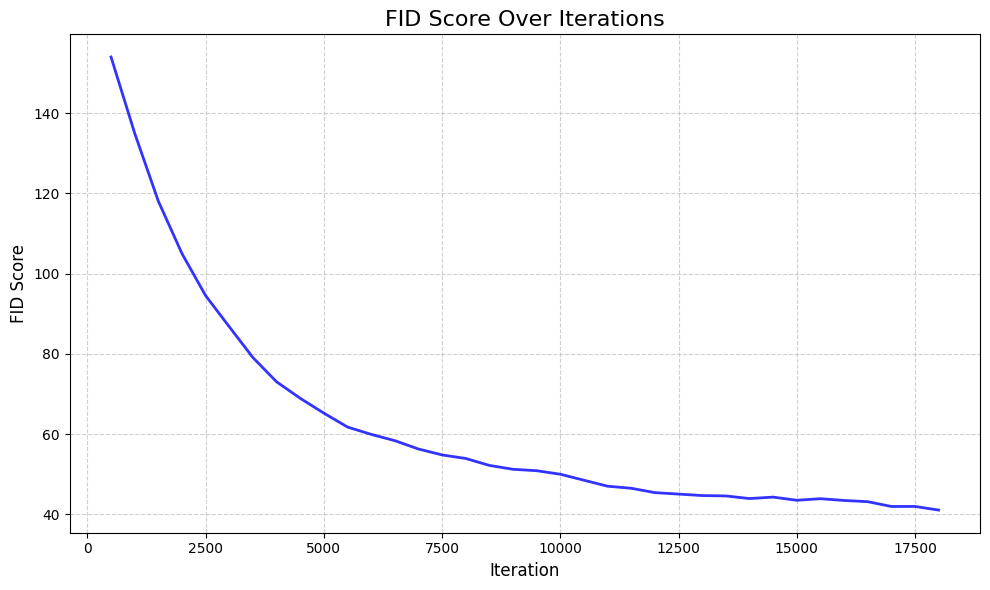

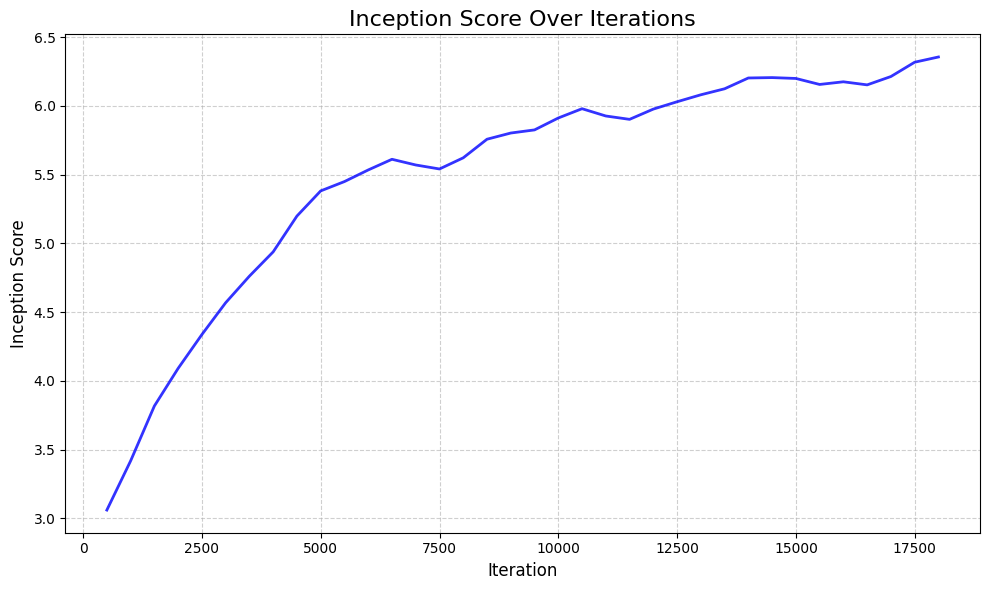

In [18]:
show_graph(ins.get_FID(), "FID Score Over Iterations", "Iteration", "FID Score")
show_graph(ins.get_IS(), "Inception Score Over Iterations", "Iteration", "Inception Score")

## Output After 20000 Iterations

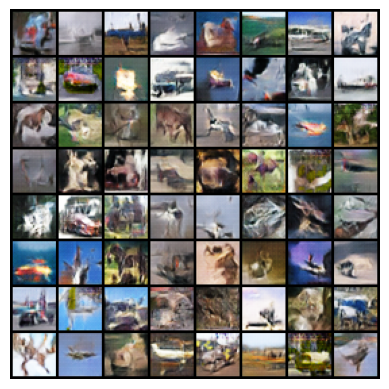

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the uploaded file or a specific directory
image_path = '/content/sample/1726322856811/fake_19800.png'  # Replace with the name or path of your uploaded image

# Open and display the image
img = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()


# Conclusion

The results already look quite promising. The training has been run over 20000 iterations. As in the graph we can see that FID score is decreasing and Inception score is increasing.This is a good indicator that the model is learning well.

The final FID score and IS score after 20000 iterations are as following.
Inception Score: 6.399(0.10431), FID: 39.886

=======================================================================================================================================================================================================